In [41]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("simObsInclined.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    
pnorm=np.log10(1e-3*(pnorm+1e-6))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
for pnorm1 in pnorm:
    lidarEchoPeak.append(np.argmax(pnorm1)*0.24)
yobsL+=np.random.randn(nt,nchan)*3
yobsLidarL=np.concatenate((yobsL,np.array(lidarEchoPeak)[:,np.newaxis]),axis=-1)

ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape
X_train=yobsL[ind_train,:]
X_test=yobsL[ind_test,:]
XLidar_train=yobsLidarL[ind_train,:]
XLidar_test=yobsLidarL[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]
zKu_train=zKu[ind_train,:]
zKu_test=zKu[ind_test,:]

neigh = KNeighborsRegressor(n_neighbors=30,weights='distance')
neighIWC = KNeighborsRegressor(n_neighbors=30,weights='distance')
neighL = KNeighborsRegressor(n_neighbors=30,weights='distance')
neighLIWC = KNeighborsRegressor(n_neighbors=30,weights='distance')
neigh.fit(X_train, y_train)
neighIWC.fit(X_train, iwc_train)
y_=neigh.predict(X_test)
iwc_=neighIWC.predict(X_test)

neighL.fit(XLidar_train, y_train)
neighLIWC.fit(XLidar_train, iwc_train)
y_=neighL.predict(XLidar_test)
iwc_=neighIWC.predict(XLidar_test)

138606


(array([  403.,  3079., 12947., 15306., 30186., 37147., 26568., 10087.,
         2551.,   332.]),
 array([ 0.   ,  1.176,  2.352,  3.528,  4.704,  5.88 ,  7.056,  8.232,
         9.408, 10.584, 11.76 ]),
 <BarContainer object of 10 artists>)

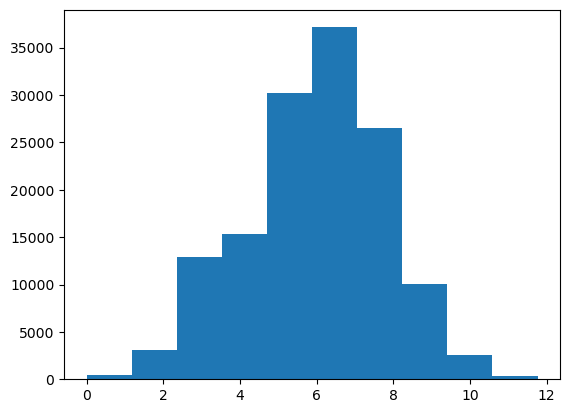

In [39]:
print(len(pnormMax))
plt.hist(lidarEchoPeak)

[[1.         0.92802166]
 [0.92802166 1.        ]]


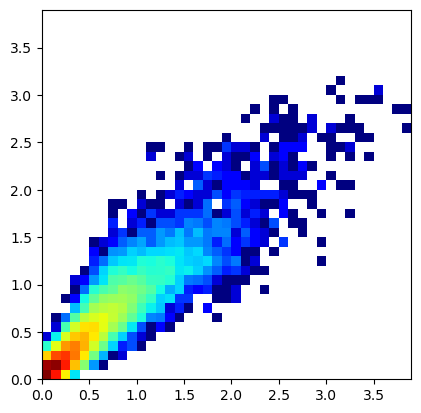

In [8]:
import matplotlib
import matplotlib.pyplot as plt
#print(dir(plt))
print(np.corrcoef(y_test,y_))
ax=plt.subplot(111)
hist2d=plt.hist2d(y_test,y_,bins=np.arange(40)*0.1,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')


In [19]:
from sklearn.cluster import KMeans
nC=36 # number of clusters
kmeans = KMeans(n_clusters=nC, random_state=0).fit(X_train)
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)

plt.figure(figsize=(10,10))
iwcCoeffL=[]
peakL=[]
iclass=0
for i in range(-4):
    for j in range(3):
        ax=plt.subplot(4,3,i*3+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(kmeans.labels_==iclass)[0]
            if len(a)>0:
                plt.plot(iwc_train[a,:].mean(axis=0),np.arange(50)*0.24)
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
#plt.savefig('iwcClassesCondTb.png')
#

<Figure size 1000x1000 with 0 Axes>

In [18]:
print(iwc_.shape)

(92866, 50)


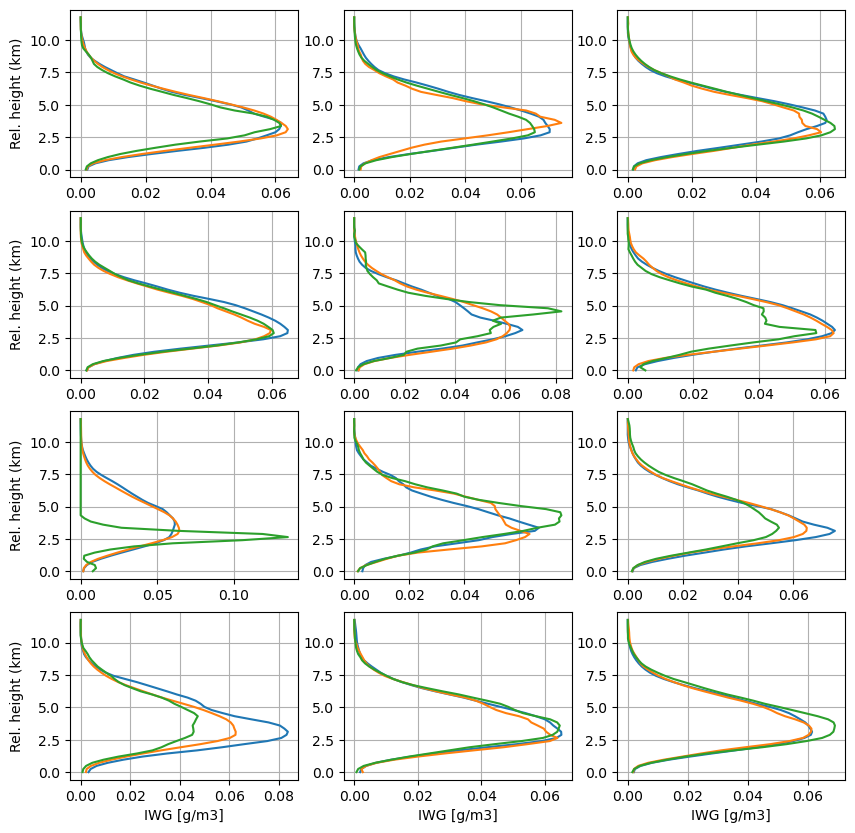

In [17]:
from sklearn.cluster import KMeans
nC=36 # number of clusters
kmeans = KMeans(n_clusters=nC, random_state=0).fit(X_train)
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)
iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(10,10))
iwcCoeffL=[]
peakL=[]
iclass=0
for i in range(-4):
    for j in range(3):
        ax=plt.subplot(4,3,i*3+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot(iwc_[a,:].mean(axis=0),np.arange(50)*0.24)
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
plt.savefig('iwcClassesSSRG.png')
#

(45740, 50)
(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_18579/263037477.py:7: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:]*np.arange(50)).sum()*0.24/iwc_test[i,:].sum()


[[1.         0.17632437]
 [0.17632437 1.        ]]


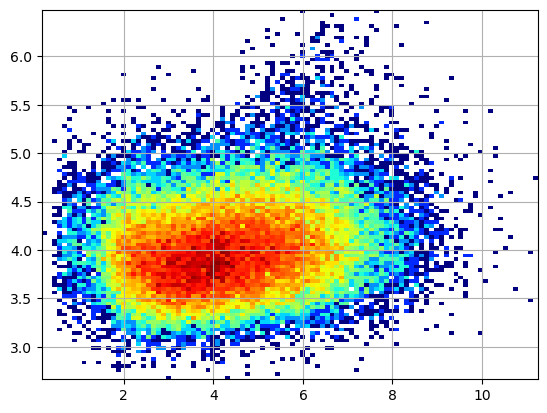

In [27]:
hgRealL=[]
hgPredL=[]
print(iwc_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwc_):
    hc1=(iwc1*np.arange(50)).sum()*0.24/iwc1.sum()
    hc2=(iwc_test[i,:]*np.arange(50)).sum()*0.24/iwc_test[i,:].sum()
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.grid()
print(np.corrcoef(hgRealL,hgPredL))
